

## Part 1 - Toy Dataset



In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

### Q1.a

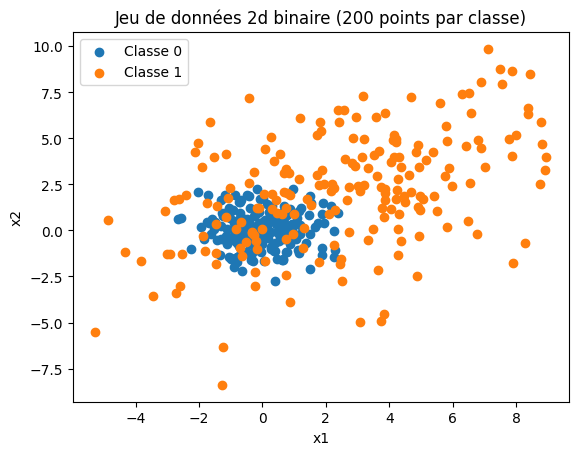

In [3]:
np.random.seed(0) 

n=200


mu0 = [0,0]
sigma0 = np.array( [[1,0],[0,1]])
X0 = np.random.multivariate_normal(mu0, sigma0, n)

mu1 = [2,2]
sigma1 = np.array([[10, 5], [5, 10]])
X1 = np.random.multivariate_normal(mu1, sigma1, n)

X = np.vstack((X0,X1))
Y = np.hstack((np.zeros(n),np.ones(n))) 

plt.scatter(X0[:, 0], X0[:, 1], label="Classe 0")
plt.scatter(X1[:, 0], X1[:, 1], label="Classe 1")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Jeu de données 2d binaire (200 points par classe)")
plt.legend()
plt.show()


### Q1.b

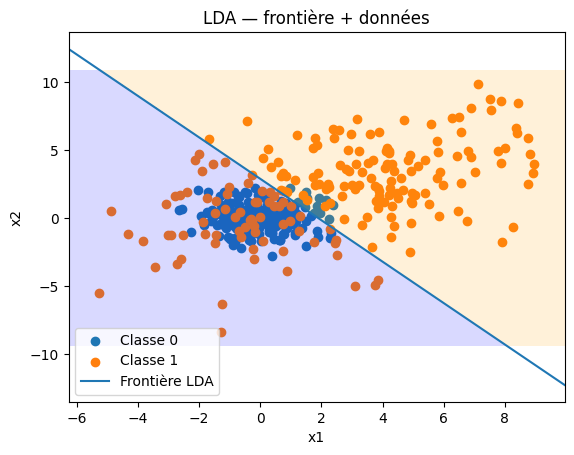

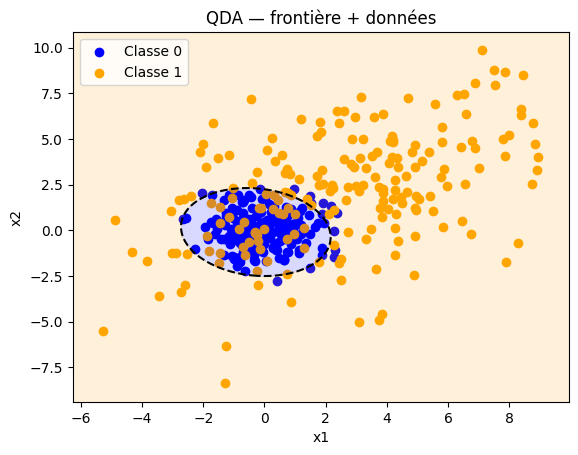

In [4]:

#QDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda = QuadraticDiscriminantAnalysis(store_covariance=True)
qda.fit(X, Y)

#LDA
def  fit_lda_mle (X,y):
    X = np.asarray(X)
    y = np.asarray(y).astype(int)
    n,p = X.shape
    idx0 = (y==0)
    idx1 = (y==1)

    n0 = idx0.sum()
    n1 = idx1.sum()

    p = n1/n #EMV Bernouilli des labels observés
    
    #EMV des moyennes conditionnelles
    m0_hat =  X[idx0].mean(axis=0) 
    m1_hat = X[idx1].mean(axis=0)

    #EMV de la covariance (commune, LDA)
    X0c = X[idx0] - m0_hat
    X1c = X[idx1] - m1_hat
    S0 = X0c.T @ X0c
    S1 = X1c.T @ X1c
    K_hat = (S0 +S1)/n

    Kinv = np.linalg.pinv(K_hat)

    #Paramètres de la fonction frontière w^T x +b
    w = Kinv @(m1_hat - m0_hat)
    b = -0.5 * (m1_hat@Kinv@m1_hat - m0_hat@Kinv@m0_hat) +np.log(p/(1-p))

    return{
        "p" : p, "m0" : m0_hat, "m1": m1_hat,
        "K" : K_hat, "Kinv" : Kinv,
        "w" : w, "b":b,
        "n0" : n0, "n1" : n1}

def predict_lda(params, X):
    w,b = params["w"], params["b"]
    s = X@w +b
    yhat = (s>=0).astype(int)
    return yhat, s

params = fit_lda_mle(X,Y)
yhat, scores = predict_lda(params,X)


#Tracé nuage + frontière LDA
plt.figure()

plt.scatter(X[:n, 0], X[:n, 1], label="Classe 0")
plt.scatter(X[n:, 0], X[n:, 1], label="Classe 1")

w, b = params["w"], params["b"]
xs = np.linspace(X[:,0].min()-1, X[:,0].max()+1, 200)
xx, yy = np.meshgrid(np.linspace(X[:,0].min()-1, X[:,0].max()+1, 400),
                     np.linspace(X[:,1].min()-1, X[:,1].max()+1, 400))
s = w[0]*xx + w[1]*yy + b
plt.contourf(xx, yy, s >= 0, levels=[-0.5,0.5,1.5], colors=["blue","orange"], alpha=0.15)

if abs(w[1]) > 1e-12:
     ys = (-b - w[0]*xs)/w[1]
     plt.plot(xs, ys, label="Frontière LDA")
else:
    x_vert = -b / w[0]
    plt.axvline(x_vert, label="Frontière LDA (verticale)")
    
plt.xlabel("x1"); plt.ylabel("x2")
plt.title("LDA — frontière + données")
plt.legend()
plt.show()

# Tracé pour la QDA

plt.figure()

plt.scatter(X[:n, 0], X[:n, 1], label="Classe 0", color="blue")
plt.scatter(X[n:, 0], X[n:, 1], label="Classe 1", color="orange")

xx, yy = np.meshgrid(
    np.linspace(X[:,0].min()-1, X[:,0].max()+1, 400),
    np.linspace(X[:,1].min()-1, X[:,1].max()+1, 400)
)
Z = qda.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)


plt.contourf(xx, yy, Z, levels=[-0.5,0.5,1.5], colors=["blue","orange"], alpha=0.15)


P1 = qda.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1].reshape(xx.shape)
plt.contour(xx, yy, P1, levels=[0.5], colors='k', linestyles='--', linewidths=1.5)

plt.xlabel("x1")
plt.ylabel("x2")
plt.title("QDA — frontière + données")
plt.legend()
plt.show()

### Q1.c



Comme vu en PC/amphi en  La frontière de décision découle directement de la règle suivante : une observation $x$ est attribuée à la classe 1 si  

$$
\quad p\, f_1(x) > (1-p)\, f_0(x),
$$
car cela équivaut au cas où la fonction de régression excède 1/2.

où $p = P(Y=1)$ et $f_k(x)$ désigne la densité gaussienne de X sachant que Y=k $ \quad k \in \{0,1\} $ :

$$
f_k(x) = \frac{1}{(2\pi)^{d/2} |\Sigma_k|^{1/2}}
\exp\!\left(-\frac{1}{2}(x - \mu_k)^\top \Sigma_k^{-1} (x - \mu_k)\right),
\quad k \in \{0,1\}.
$$

La frontière de décision est donc donnée par l’équation  

$$
p\, f_1(x) = (1-p)\, f_0(x),
$$

introduisant la fonction logarithmique aux deux cotés, on trouve :

**Cas LDA :** si les matrices de covariance sont identiques, $\Sigma_0 = \Sigma_1 = \Sigma$,  
les termes quadratiques en $x$ s’annulent dans l’égalité précédente ,  
et la frontière devient **linéaire** :  

$$
w^\top x + b = 0,
\qquad
w = \Sigma^{-1}(\mu_1 - \mu_0),
\qquad
b = -\tfrac{1}{2}(\mu_1 + \mu_0)^\top w + \log\frac{p}{1-p}.
$$

---

**Cas QDA :** si les covariances diffèrent, $\Sigma_0 \neq \Sigma_1$,  
les termes quadratiques $(x^\top \Sigma_k^{-1} x)$ ne s’annulent plus,  
et la frontière  

$$
p\, f_1(x) = (1-p)\, f_0(x)
$$

devient une **courbe quadratique** (ellipse, parabole ou hyperbole selon les matrices de covariance comme cité en PC les valeurs propres donnent une étude sur les valeur propre donne une idée sur le shape de notre frontiére de décision).  



Ainsi, la LDA produit une séparation **linéaire**,  
tandis que la QDA autorise des **frontières quadratiques plus flexibles**,  
du fait de la différence des covariances entre classes.

---




### Q1.d

Sur le jeu de données simulé, la $\textbf{QDA}$ obtient de meilleures performances de classification que la $\textbf{LDA}$. 
En effet, les deux classes présentent des dispersions très différentes (leurs matrices de covariance $\Sigma_0$ et $\Sigma_1$ ne sont pas égales). 
Dans ce contexte, l'hypothèse fondamentale de la LDA --- 
$$
\Sigma_0 = \Sigma_1 = \Sigma
$$
--- n'est pas vérifiée, ce qui explique que sa frontière linéaire ne parvienne pas à séparer correctement les nuages de points.

À l’inverse, la QDA autorise des covariances distinctes : 
$$
\Sigma_0 \neq \Sigma_1,
$$
et donc des frontières $\textbf{quadratiques}$ capables de s’adapter à la forme réelle des classes. 


La LDA est plus "simple", mais adaptée uniquement lorsque les classes ont des covariances similaires ; elle impose une séparation linéaire.
La QDA est plus flexible (frontière courbe) et mieux adaptée ici car les classes sont de forme et de dispersion différentes.


Ainsi, la meilleure performance de la QDA s’explique directement par la non-validité de l’hypothèse($\Sigma_0 = \Sigma_1$) requise pour la LDA.


## Part 2 - Classification on MNIST

### Q2.a

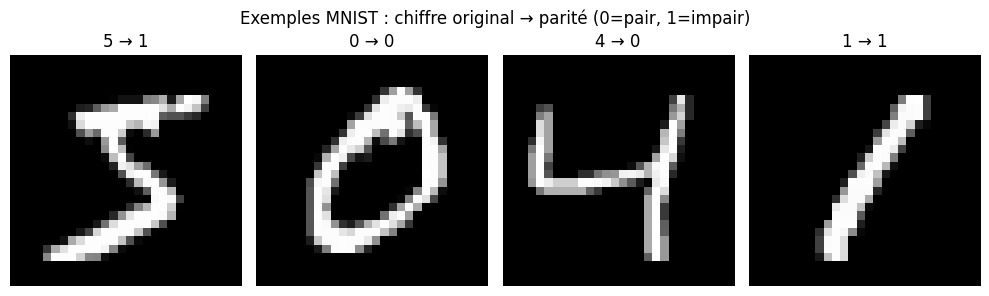

In [21]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, cross_val_score

transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

X = torch.cat([train_data.data, test_data.data]).float() / 255.0
y = torch.cat([train_data.targets, test_data.targets])
y_binary = (y % 2 != 0).long()  # 0=even, 1=odd


## affichage: 

n_examples = 10

fig, axes = plt.subplots(1, 4, figsize=(10,3))

for i in range(4):
    img = X[i]
    label_original = y[i].item()
    label_binary = y_binary[i].item()
    
    axes[i].imshow(img.squeeze(), cmap="gray")
    axes[i].set_title(f"{label_original} → {label_binary}")
    axes[i].axis("off")

plt.suptitle("Exemples MNIST : chiffre original → parité (0=pair, 1=impair)", fontsize=12)
plt.tight_layout()
plt.show()


### Q2.b

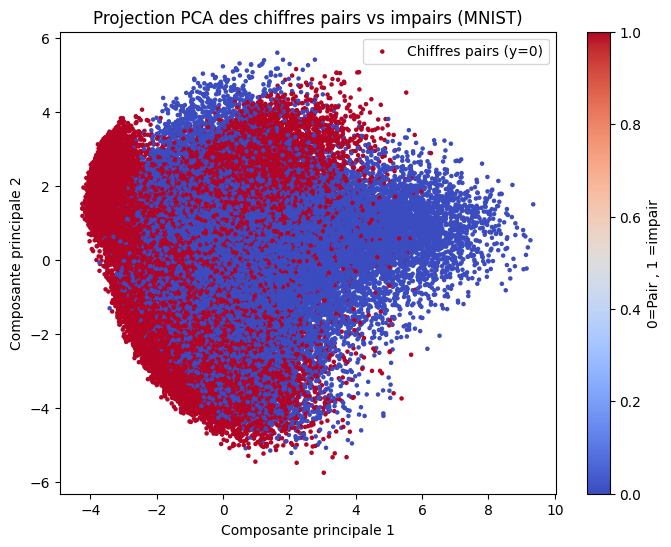

In [25]:
X_flat = X.view(X.size(0), -1) 
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_flat.numpy())
X_pca.shape

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c = y_binary.numpy(), cmap = 'coolwarm', label="Chiffres pairs (y=0)", s=5)
#plt.scatter(X_pca[y_binary==1, 0], X_pca[y_binary==1, 1], alpha=0.4, label="Chiffres impairs (y=1)", s=5)
plt.colorbar(label ='0=Pair , 1 =impair')
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.title("Projection PCA des chiffres pairs vs impairs (MNIST)")
plt.legend()
plt.show()

### Q2.c

In [36]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, recall_score


lda = LinearDiscriminantAnalysis()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracy_scores = cross_val_score(lda, X_pca, y_binary.numpy(), cv=cv, scoring='accuracy')
mean_accuracy = np.mean(accuracy_scores)

recall_scorer = make_scorer(recall_score)
recall_scores = cross_val_score(lda, X_pca, y_binary.numpy(), cv=cv, scoring=recall_scorer)
mean_recall = np.mean(recall_scores)

print("Mean Accuracy:", mean_accuracy)
print("Mean Recall:", mean_recall)

Mean Accuracy: 0.6525000000000001
Mean Recall: 0.7096850339657328


### Q2.d

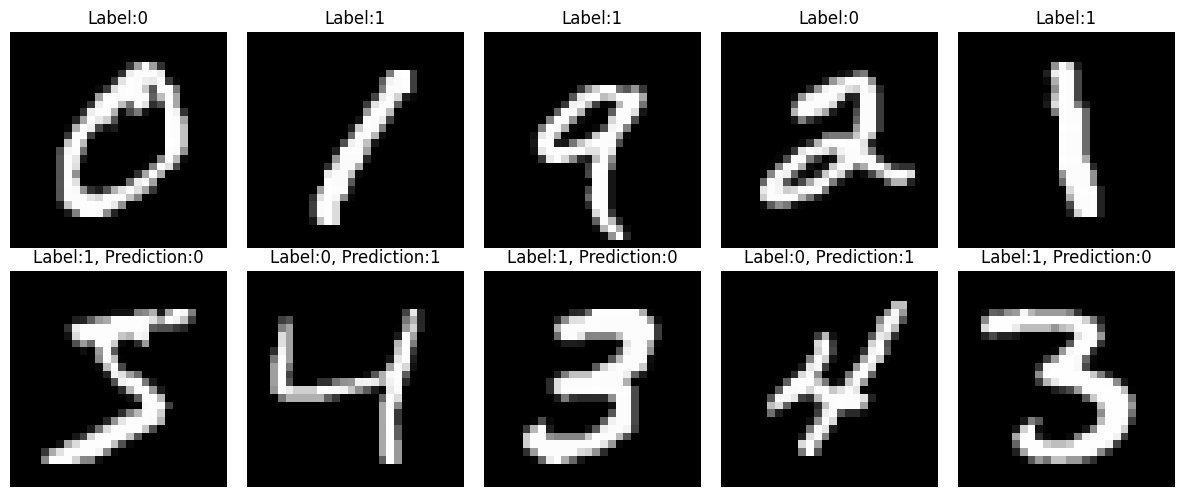

In [37]:
lda.fit(X_pca, y_binary.numpy())
y_pred = lda.predict(X_pca)
correct_idx = np.where(y_pred == y_binary.numpy())[0]
incorrect_idx = np.where(y_pred != y_binary.numpy())[0]
fig, axes = plt.subplots(2, 5, figsize=(12,5))
for i, idx in enumerate(correct_idx[:5]):
    axes[0, i].imshow(X_flat.numpy()[idx].reshape(28,28), cmap='gray')
    axes[0, i].set_title(f"Label:{y_binary.numpy()[idx]}")
    axes[0, i].axis('off')
axes[0,0].set_ylabel("Correct")
for i, idx in enumerate(incorrect_idx[:5]):
    axes[1, i].imshow(X_flat.numpy()[idx].reshape(28,28), cmap='gray')
    axes[1, i].set_title(f"Label:{y_binary.numpy()[idx]}, Prediction:{y_pred[idx]}")
    axes[1, i].axis('off')
axes[1,0].set_ylabel("Incorrect")
plt.tight_layout()
plt.show()

### Q2.e 

In [38]:
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(nn.Linear(32*7*7, 64), nn.ReLU(), nn.Linear(64, 1))
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        h = self.fc[0:2](x)  # penultimate activations
        out = self.fc[2](h)
        return out, h

model = SmallCNN()
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()

dataset = TensorDataset(X.unsqueeze(1), y_binary.float())
loader = DataLoader(dataset, batch_size=128, shuffle=True)

n_epochs = 5
model.train()

for epoch in range(n_epochs):
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        out, _ = model(xb)
        train_loss = loss_fn(out.squeeze(), yb)
        opt.zero_grad()
        train_loss.backward()
        opt.step()
        
    print(f"Epoch {epoch+1}, loss={train_loss.item():.4f}")

Epoch 1, loss=0.0703
Epoch 2, loss=0.0420
Epoch 3, loss=0.0490
Epoch 4, loss=0.0206
Epoch 5, loss=0.0161


In [39]:
model.eval()
all_features = []
all_labels = []

with torch.no_grad():
    for xb, yb in loader:
        xb = xb.to(device)
        out, h = model(xb)
        all_features.append(h.cpu())
        all_labels.append(yb)

X_cnn = torch.cat(all_features).numpy()
y_cnn = torch.cat(all_labels).numpy()

### Q2.f

In [40]:

lda = LinearDiscriminantAnalysis()

accuracy = cross_val_score(lda, X_cnn, y_cnn, cv=5, scoring='accuracy')
recall = cross_val_score(lda, X_cnn, y_cnn, cv=5, scoring=make_scorer(recall_score))

print(f"Mean Accuracy: {np.mean(accuracy):.4f}")
print(f"Mean Recall:   {np.mean(recall):.4f}")

Mean Accuracy: 0.9860
Mean Recall:   0.9836


### Q2.g

Les modèles linéaires supposent que les classes peuvent être séparées par une frontière linéaire. Sur les pixels bruts, cette hypothèse n’est pas vérifiée car les chiffres varient beaucoup (position, taille, épaisseur) et les valeurs de pixels ne représentent pas directement la forme ou la structure du chiffre. Les relations entre pixels sont complexes et non linéaires, ce qui rend la séparation difficile pour un modèle linéaire.
Le CNN apprend à extraire des caractéristiques plus abstraites et pertinentes que les pixels bruts. Les couches de convolution détectent des motifs comme les bords ou les formes, puis les combinent pour former une représentation plus stable et plus discriminante des chiffres. Ces nouvelles caractéristiques rendent les classes beaucoup plus faciles à séparer avec un modèle linéaire.

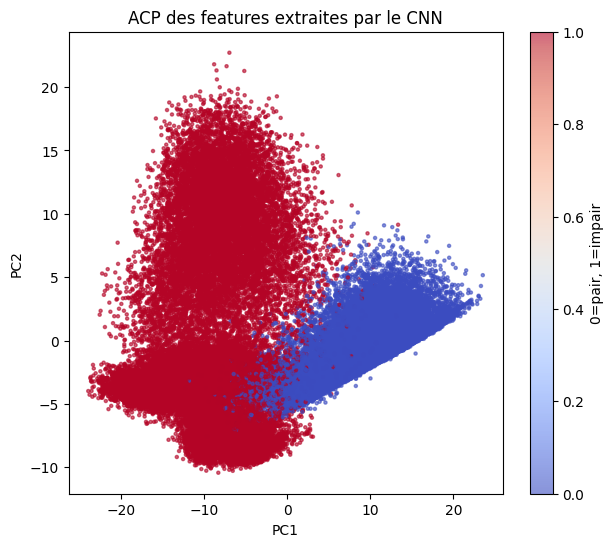

In [41]:
pca = PCA(n_components=2)
X_cnn_pca = pca.fit_transform(X_cnn)

plt.figure(figsize=(7,6))
plt.scatter(X_cnn_pca[:,0], X_cnn_pca[:,1], c=y_cnn, cmap='coolwarm', s=5, alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("ACP des features extraites par le CNN")
plt.colorbar(label='0=pair, 1=impair')
plt.show()